## BTC price forecasting with Deep Learning

In [1]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading/Reading in the Data
df = pd.read_csv("./data/BTC-USD.csv", sep=';')

Using TensorFlow backend.


In [2]:
# Data Preprocessing
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Index")[['BTC-USD.Adjusted']]
df = df.set_index(pd.to_datetime(df.index))

# Test/Train split
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns, index=df_train.index)
df.describe()

,BTC-USD.Adjusted
count,1174.000000
mean,0.186816
std,0.202096
min,0.000000
25%,0.015462
50%,0.120414
75%,0.323015
max,1.000000


**Walking window function**  
We look back on *n_steps* to predict *n_steps_out*
Fore example use past 30 values (one month) to predict next 7  values (next week), then
we move our window of size 30 one (!) step ahead, not 30. So with dataset size *N* we end up with *N-n_steps_out* seq

In [3]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

**Create model**

In [4]:
# How many periods looking back to train
n_per_in  = 30

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(df['BTC-USD.Adjusted'].tolist(), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [5]:
# Instantiating the model
model = Sequential()

# Activation func
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))
# Hidden layers
model.add(LSTM(90, activation=activ, dropout=0.1, return_sequences=True))

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 90)            43560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 10)                4040      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 51,550
Trainable params: 51,550
Non-trainable params: 0
_________________________________________________________________


**Complie model**

In [6]:
model.compile(loss='mse',
              optimizer='adam',
              metrics=['mae', 'acc'])

**Fit model**

In [16]:
from keras.callbacks import ModelCheckpoint

filepath = "weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

history = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[checkpoint])

**Visualize training results**

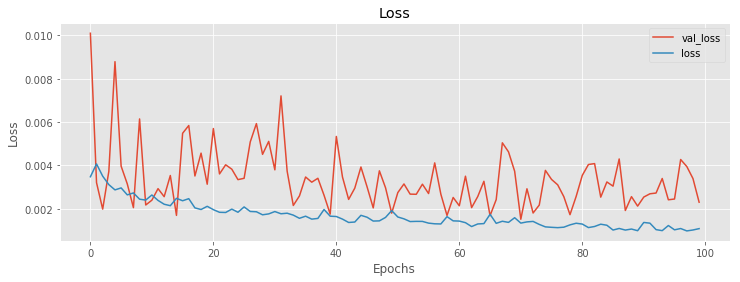

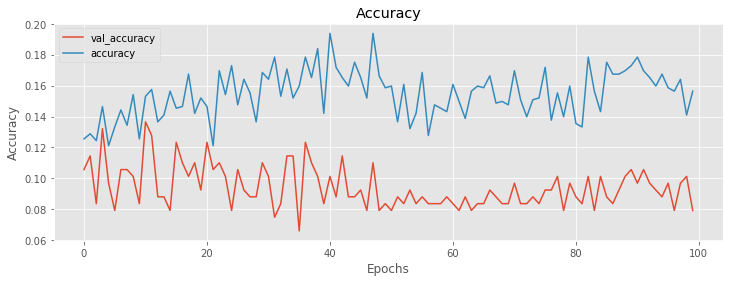

In [17]:
history = history.history

plt.figure(figsize=(12,4))
plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.legend(['val_loss', 'loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(history['val_acc'])
plt.plot(history['acc'])
plt.legend(['val_accuracy', 'accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

**Evaluate model on test set**

In [18]:
test_set = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns, index=df_test.index)
X_test, y_test = split_sequence(test_set['BTC-USD.Adjusted'].tolist(), n_per_in, n_per_out)

Actual vs Predicted values
7463.11		7692.83
7761.24		7611.49
7569.63		8152.63
7424.29		7941.03
7321.99		8024.03
7320.15		7648.74
7252.03		7893.33
7448.31		8188.87
7547.0		8138.25
7536.2		8076.0


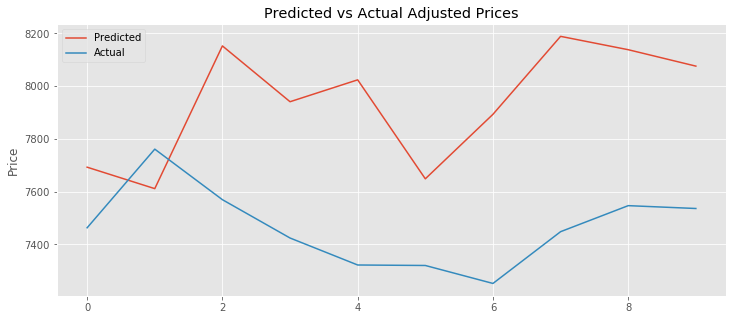

In [19]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X_test[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
pred = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y_test[-1].reshape(-1,1)).tolist()

# Print actual and predicted values
print("Actual vs Predicted values")
for i in range(len(pred)):
    print(f"{round(actual[i][0],2)}\t\t{round(pred[i][0],2)}")

plt.plot(pred, label='Predicted')
plt.plot(actual, label='Actual')

plt.title("Predicted vs Actual Adjusted Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_LSTM_res.png")
plt.show()

            BTC-USD.Adjusted
2019-12-09       7484.343389
2019-12-10       7397.565532
2019-12-11       7601.422526
2019-12-12       7539.276935
2019-12-13       7517.249614
2019-12-14       7512.422001
2019-12-15       7514.696456
2019-12-16       7431.485502
2019-12-17       7610.750601
2019-12-18       7426.268652


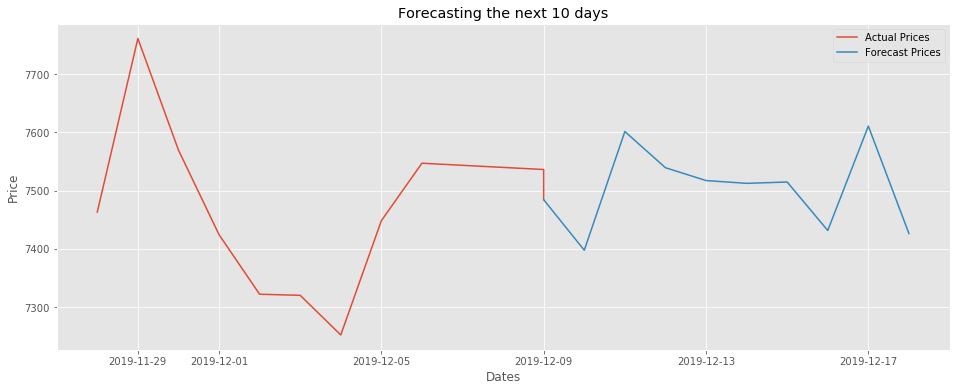

In [20]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(test_set.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=test_set.index[-1], periods=len(yhat), freq="D"),
                     columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(test_set[['BTC-USD.Adjusted']].tail(pers)),
                                               index=test_set['BTC-USD.Adjusted'].tail(pers).index,
                                               columns=test_set.columns).append(preds.head(1))

# Plotting
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Forecast Prices")

plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()